# Access locations and times of Veery encounters

For this challenge, you will use a database called the [Global
Biodiversity Information Facility (GBIF)](https://www.gbif.org/). GBIF
is compiled from species observation data all over the world, and
includes everything from museum specimens to photos taken by citizen
scientists in their backyards.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Explore GBIF</div></div><div class="callout-body-container callout-body"><p>Before your get started, go to the <a
href="https://www.gbif.org/occurrence/search">GBIF occurrences search
page</a> and explore the data.</p></div></div>

> **Contribute to open data**
>
> You can get your own observations added to GBIF using
> [iNaturalist](https://www.inaturalist.org/)!

### Set up your code to prepare for download

We will be getting data from a source called [GBIF (Global Biodiversity
Information Facility)](https://www.gbif.org/). We need a package called
`pygbif` to access the data, which may not be included in your
environment. Install it by running the cell below:

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Import packages</div></div><div class="callout-body-container callout-body"><p>In the imports cell, we’ve included some packages that you will need.
Add imports for packages that will help you:</p>
<ol type="1">
<li>Work with reproducible file paths</li>
<li>Work with tabular data</li>
</ol></div></div>

In [1]:
import time
import zipfile
from getpass import getpass
from glob import glob

import os
import pathlib

from getpass import getpass
from glob import glob

import geopandas as gpd
import pandas as pd

import pygbif.occurrences as occ
import pygbif.species as species

# get month names
import calendar

# libraries for Dynamic mapping
import geoviews as gv
import hvplot.pandas
import cartopy
import cartopy.crs as ccrs
import panel as pn
pn.extension()



/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Create data directory in the home folder
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'species',
)
os.makedirs(data_dir, exist_ok=True)

# Define the directory name for GBIF data
gbif_dir = os.path.join(data_dir, 'gbif_siberian')
gbif_dir

'/home/jovyan/earth-analytics/data/species/gbif_siberian'

:::

### Register and log in to GBIF

You will need a [GBIF account](https://www.gbif.org/) to complete this
challenge. You can use your GitHub account to authenticate with GBIF.
Then, run the following code to save your credentials on your computer.

> **Warning**
>
> Your email address **must** match the email you used to sign up for
> GBIF!

> **Tip**
>
> If you accidentally enter your credentials wrong, you can set
> `reset_credentials=True` instead of `reset_credentials=False`.

In [3]:
reset_credentials = False
# GBIF needs a username, password, and email
credentials = dict(
    GBIF_USER=(input, 'username'),
    GBIF_PWD=(getpass, 'password'),
    GBIF_EMAIL=(input, 'email'),
)
for env_variable, (prompt_func, prompt_text) in credentials.items():
    # Delete credential from environment if requested
    if reset_credentials and (env_variable in os.environ):
        os.environ.pop(env_variable)
    # Ask for credential and save to environment
    if not env_variable in os.environ:
        os.environ[env_variable] = prompt_func(prompt_text)

### Get the species key

> ** Your task**
>
> 1.  Replace the `species_name` with the name of the species you want
>     to look up
> 2.  Run the code to get the species key

In [4]:
# Query species
species_info = species.name_lookup('grus leucogeranus', rank='SPECIES')

# Get the first result
first_result = species_info['results'][0]

# Get the species key (nubKey)
species_key = first_result['nubKey']

# Check the result
first_result['species'], species_key

('Grus leucogeranus', 2474961)

In [5]:
species_key

2474961

### Download data from GBIF

::: {.callout-task title=“Submit a request to GBIF”

1.  Replace `csv_file_pattern` with a string that will match **any**
    `.csv` file when used in the `glob` function. HINT: the character
    `*` represents any number of any values except the file separator
    (e.g. `/`)

2.  Add parameters to the GBIF download function, `occ.download()` to
    limit your query to:

    -   observations
    -   from 2023
    -   with spatial coordinates.

3.  Then, run the download. **This can take a few minutes**. :::

    -   Can check progress at <https://www.gbif.org/user/download>.

In [6]:
"speciesKey =" + str(species_key)

'speciesKey =2474961'

In [7]:
# Only download once
gbif_pattern = os.path.join(gbif_dir, '*.csv')
if not glob(gbif_pattern):
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF
        gbif_query = occ.download([
            "speciesKey = " + str(species_key),
            "hasCoordinate = TRUE",
            #"year = 2023",
        ])
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

    # Wait for the download to build
    download_key = os.environ['GBIF_DOWNLOAD_KEY']
    wait = occ.download_meta(download_key)['status']
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(download_key)['status']
        time.sleep(5)

    # Download GBIF data
    download_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'], 
        path=data_dir)

    # Unzip GBIF data
    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=gbif_dir)

# Find the extracted .csv file path (take the first result)
gbif_path = glob(gbif_pattern)[0]

download key is 0020917-241007104925546
GBIF.org (17 October 2024) GBIF Occurrence Download https://doi.org/10.15468/dl.4d3k48

In [8]:
gbif_path

'/home/jovyan/earth-analytics/data/species/gbif_siberian/0002798-241024112534372.csv'

### Load the GBIF data into Python

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Load GBIF data</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Look at the beginning of the file you downloaded using the code
below. What do you think the <strong>delimiter</strong> is?</li>
<li>Run the following code cell. What happens?</li>
<li>Uncomment and modify the parameters of <code>pd.read_csv()</code>
below until your data loads successfully and you have only the columns
you want.</li>
</ol></div></div>

You can use the following code to look at the beginning of your file:

I copied from <https://github.com/lauren-alexandra/lauren-alexandra.github.io/blob/main/willow-flycatcher-distribution/willow-flycatcher-distribution.ipynb>
and Lauren Gleason

In [9]:
!head -n 2 $gbif_path 

gbifID	datasetKey	occurrenceID	kingdom	phylum	class	order	family	genus	species	infraspecificEpithet	taxonRank	scientificName	verbatimScientificName	verbatimScientificNameAuthorship	countryCode	locality	stateProvince	occurrenceStatus	individualCount	publishingOrgKey	decimalLatitude	decimalLongitude	coordinateUncertaintyInMeters	coordinatePrecision	elevation	elevationAccuracy	depth	depthAccuracy	eventDate	day	month	year	taxonKey	speciesKey	basisOfRecord	institutionCode	collectionCode	catalogNumber	recordNumber	identifiedBy	dateIdentified	license	rightsHolder	recordedBy	typeStatus	establishmentMeans	lastInterpreted	mediaType	issue
985829831	4fa7b334-ce0d-4e88-aaae-2e0c138d049e	URN:catalog:CLO:EBIRD:OBS131267733	Animalia	Chordata	Aves	Gruiformes	Gruidae	Grus	Grus leucogeranus		SPECIES	Leucogeranus leucogeranus (Pallas, 1773)	Leucogeranus leucogeranus		IN	Bharatpur--Keoladeo Ghana NP	Rajasthan	PRESENT	7	e2e717bf-551a-4917-bdc9-4fa0f342c530	27.161905	77.5228							1991-02-03	3	2	1991	9531123

In [10]:
# Load the GBIF data
gbif_df = pd.read_csv(
    gbif_path, 
    delimiter='\t',
    index_col='gbifID',
    on_bad_lines='skip',
    usecols=['gbifID', 'month', 'year', 'countryCode', 'stateProvince', 'decimalLatitude', 'decimalLongitude']
)
gbif_df.head()

,countryCode,stateProvince,decimalLatitude,decimalLongitude,month,year
gbifID,,,,,,
985829831,IN,Rajasthan,27.161905,77.522800,2.0,1991.0
979229641,CN,Jiangxi,28.870571,116.433170,11.0,1988.0
978902062,IR,Mazandaran,36.667110,52.550186,11.0,2011.0
978782158,IN,Rajasthan,27.161905,77.522800,1.0,1991.0
977810003,IN,Rajasthan,27.161905,77.522800,1.0,1992.0


## Convert GBIF data to a GeoDataFrame by Month

In [11]:
gdf_monthly = (
    gpd.GeoDataFrame(
        gbif_df, 
        geometry=gpd.points_from_xy(
            gbif_df.decimalLongitude, 
            gbif_df.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['month', 'year', 'geometry']]
)

gdf_monthly

,month,year,geometry
gbifID,,,
985829831,2.0,1991.0,POINT (77.5228 27.1619)
979229641,11.0,1988.0,POINT (116.43317 28.87057)
978902062,11.0,2011.0,POINT (52.55019 36.66711)
978782158,1.0,1991.0,POINT (77.5228 27.1619)
977810003,1.0,1992.0,POINT (77.5228 27.1619)
...,...,...,...
1019036144,6.0,1983.0,POINT (-90 43.75)
1019036117,6.0,1983.0,POINT (-90 43.75)
1019036092,6.0,1983.0,POINT (-90 43.75)


### Download and save ecoregion boundaries

Ecoregions represent boundaries formed by biotic and abiotic conditions: geology, landforms, soils, vegetation, land use, wildlife, climate, and hydrology.

In [12]:
# Set up the ecoregion boundary URL
ecoregions_url = "https://storage.googleapis.com/teow2016/Ecoregions2017.zip"

# Set up a path to save the data on your machine
ecoregions_dir = os.path.join(data_dir, 'wwf_ecoregions')

# Make the ecoregions directory
os.makedirs(ecoregions_dir, exist_ok=True)

# Join ecoregions shapefile path
ecoregions_path = os.path.join(ecoregions_dir, 'wwf_ecoregions.shp')

# Only download once
if not os.path.exists(ecoregions_path):
    ecoregions_gdf = gpd.read_file(ecoregions_url)
    ecoregions_gdf.to_file(ecoregions_path)

In [13]:
%%bash
find ~/earth-analytics/data/species -name '*.shp'

/home/jovyan/earth-analytics/data/species/wwf_ecoregions/wwf_ecoregions.shp


In [14]:
# Open up the ecoregions boundaries
ecoregions_gdf = (
    gpd.read_file(ecoregions_path)
    .rename(columns={
        'ECO_NAME': 'name',
        'SHAPE_AREA': 'area'})
    [['name', 'area', 'geometry']]
)

# Name the index so it will match the other data later on
ecoregions_gdf.index.name = 'ecoregion'

In [15]:
ecoregions_gdf

,name,area,geometry
ecoregion,,,
0,Adelie Land tundra,0.038948,"MULTIPOLYGON (((158.7141 -69.60657, 158.71264 ..."
1,Admiralty Islands lowland rain forests,0.170599,"MULTIPOLYGON (((147.28819 -2.57589, 147.2715 -..."
2,Aegean and Western Turkey sclerophyllous and m...,13.844952,"MULTIPOLYGON (((26.88659 35.32161, 26.88297 35..."
3,Afghan Mountains semi-desert,1.355536,"MULTIPOLYGON (((65.48655 34.71401, 65.52872 34..."
4,Ahklun and Kilbuck Upland Tundra,8.196573,"MULTIPOLYGON (((-160.26404 58.64097, -160.2673..."
...,...,...,...
842,Sulawesi lowland rain forests,9.422097,"MULTIPOLYGON (((117.33111 -7.53306, 117.30525 ..."
843,East African montane forests,5.010930,"MULTIPOLYGON (((36.7375 -3.13, 36.7375 -3.1316..."
844,Eastern Arc forests,0.890325,"MULTIPOLYGON (((36.38 -8.96583, 36.38 -8.96667..."


In [16]:
%store ecoregions_gdf gdf_monthly

Stored 'ecoregions_gdf' (GeoDataFrame)
Stored 'gdf_monthly' (GeoDataFrame)


Identify the ecoregion for each observation

In [17]:
gbif_ecoregion_gdf = (
    ecoregions_gdf
    # Match the coordinate reference system of the GBIF data and the ecoregions
    # transform geometries to a new coordinate reference system
    .to_crs(gdf_monthly.crs)
    # Find ecoregion for each observation
    # spatial join
    .sjoin(
        gdf_monthly,
        how='inner', 
        predicate='contains')
    # Select the required columns
    [['month', 'year', 'name']]
)
gbif_ecoregion_gdf

,month,year,name
ecoregion,,,
5,3.0,2015.0,Al-Hajar foothill xeric woodlands and shrublands
5,7.0,2014.0,Al-Hajar foothill xeric woodlands and shrublands
5,3.0,2015.0,Al-Hajar foothill xeric woodlands and shrublands
5,12.0,2017.0,Al-Hajar foothill xeric woodlands and shrublands
8,12.0,2011.0,Alashan Plateau semi-desert
...,...,...,...
802,2.0,2023.0,Yellow Sea saline meadow
802,2.0,2015.0,Yellow Sea saline meadow
802,1.0,2018.0,Yellow Sea saline meadow


Count the observations in each ecoregion each year and month

In [18]:
def get_yearly_regional_observations(df, region_type, occurrence_name):

    # Filter out early observation
    df = df[df['year'] > 1960]

    occurrence_df = (
        df
        # For each region, for each month...
        .groupby([region_type, 'year'])
        # count the number of occurrences
        .agg(occurrences=(occurrence_name, 'count'))
    )

    # Get rid of rare observations (possible misidentification)
    occurrence_df = occurrence_df[occurrence_df["occurrences"] > 1]

    # Take the mean by region
    mean_occurrences_by_region = (
        occurrence_df
        .groupby([region_type])
        .mean()
    )

    # Take the mean by year
    mean_occurrences_by_year = (
        occurrence_df
        .groupby(['year'])
        .mean()
    )

    # Normalize by space and time for sampling effort
    # This accounts for the number of active observers in each location and time of year
    occurrence_df['norm_occurrences'] = (
        occurrence_df
        / mean_occurrences_by_region
        / mean_occurrences_by_year
    )

    return occurrence_df

In [19]:
def get_monthly_regional_observations(df, region_type, occurrence_name):

    occurrence_df = (
        df
        # For each region, for each month...
        .groupby([region_type, 'month'])
        # count the number of occurrences
        .agg(occurrences=(occurrence_name, 'count'))
    )

    # Get rid of rare observations (possible misidentification)
    occurrence_df = occurrence_df[occurrence_df["occurrences"] > 1]

    # Take the mean by region
    mean_occurrences_by_region = (
        occurrence_df
        .groupby([region_type])
        .mean()
    )

    # Take the mean by month
    mean_occurrences_by_month = (
        occurrence_df
        .groupby(['month'])
        .mean()
    )

    # Normalize by space and time for sampling effort
    # This accounts for the number of active observers in each location and time of year
    occurrence_df['norm_occurrences'] = (
        occurrence_df
        / mean_occurrences_by_region
        / mean_occurrences_by_month
    )

    return occurrence_df

In [20]:
occurrence_month_df = get_monthly_regional_observations(gbif_ecoregion_gdf, 'ecoregion', 'name')
occurrence_month_df

occurrences  norm_occurrences
ecoregion month                               
5         3.0              2          0.100000
24        5.0              6          0.166667
          9.0              2          0.166667
53        3.0              9          0.100000
74        1.0              3          0.016949
...                      ...               ...
758       5.0             20          0.141093
          6.0             16          0.067725
802       1.0              4          0.022599
          2.0              3          0.026810
          12.0             2          0.013863

[78 rows x 2 columns]

In [21]:
occurrence_year_df = get_yearly_regional_observations(gbif_ecoregion_gdf, 'ecoregion', 'name')
occurrence_year_df

occurrences  norm_occurrences
ecoregion year                                 
5         2015.0            2          0.176471
24        2014.0            2          0.156250
          2017.0            2          0.066667
          2024.0            2          0.137931
53        2020.0            4          0.062378
...                       ...               ...
758       1996.0            3          0.084746
802       2014.0            2          0.125000
          2015.0            3          0.211765
          2018.0            3          0.031169
          2023.0            2          0.032520

[135 rows x 2 columns]

<Axes: xlabel='year', ylabel='norm_occurrences'>

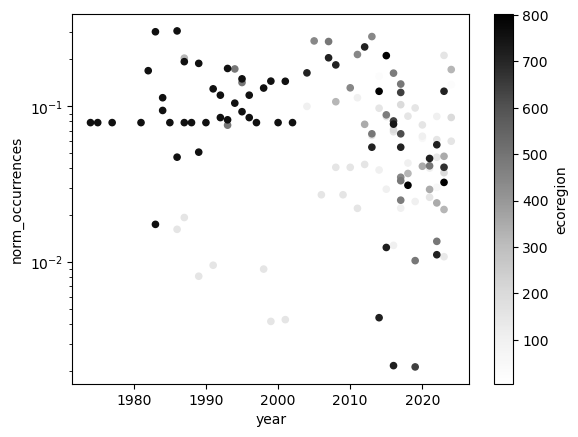

In [22]:
# plot to check distrubions 
occurrence_year_df.reset_index().plot.scatter(
    x='year', y='norm_occurrences', c='ecoregion',
    logy=True
)

Create a simplified GeoDataFrame for plot

In [23]:
"""
Streamlining plotting with hvplot by simplifying the geometry, projecting it to a Mercator projection that is compatible with
geoviews, and cropping off areas in the Arctic.
"""

# Speed up processing
ecoregions_gdf.geometry = ecoregions_gdf.simplify(
    .1, preserve_topology=False)

# Change the CRS to Mercator for mapping
ecoregions_gdf = ecoregions_gdf.to_crs(ccrs.Mercator())

ecoregions_gdf

,name,area,geometry
ecoregion,,,
0,Adelie Land tundra,0.038948,MULTIPOLYGON EMPTY
1,Admiralty Islands lowland rain forests,0.170599,"POLYGON ((16411777.375 -229101.376, 16384825.7..."
2,Aegean and Western Turkey sclerophyllous and m...,13.844952,"MULTIPOLYGON (((3391149.749 4336064.109, 33846..."
3,Afghan Mountains semi-desert,1.355536,"MULTIPOLYGON (((7369001.698 4093509.259, 73168..."
4,Ahklun and Kilbuck Upland Tundra,8.196573,"MULTIPOLYGON (((-17930832.005 8046779.358, -17..."
...,...,...,...
842,Sulawesi lowland rain forests,9.422097,"MULTIPOLYGON (((14113374.546 501721.962, 14128..."
843,East African montane forests,5.010930,"MULTIPOLYGON (((4298787.669 -137583.786, 42727..."
844,Eastern Arc forests,0.890325,"MULTIPOLYGON (((4267432.68 -493759.165, 428533..."


In [24]:
%store gbif_path
%who

Stored 'gbif_path' (str)
calendar	 cartopy	 ccrs	 credentials	 data_dir	 ecoregions_dir	 ecoregions_gdf	 ecoregions_path	 ecoregions_url	 
env_variable	 first_result	 gbif_df	 gbif_dir	 gbif_ecoregion_gdf	 gbif_path	 gbif_pattern	 gdf_monthly	 get_monthly_regional_observations	 
get_yearly_regional_observations	 getpass	 glob	 gpd	 gv	 hvplot	 occ	 occurrence_month_df	 occurrence_year_df	 
os	 pathlib	 pd	 pn	 prompt_func	 prompt_text	 reset_credentials	 species	 species_info	 
species_key	 time	 zipfile	 


Mapping monthly distribution

In [25]:
# Join the occurrences with the plotting GeoDataFrame
occurrence_gdf = ecoregions_gdf.join(occurrence_year_df[['norm_occurrences']])

# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = occurrence_gdf.total_bounds

# Define the slider widget
slider = pn.widgets.DiscreteSlider(
    name='year', 
    options={i: i for i in range(1970, 2024)}
)

occurrence_gdf

name       area  \
ecoregion year                                                                  
5         2015.0  Al-Hajar foothill xeric woodlands and shrublands   4.099668   
24        2014.0                                Amur meadow steppe  15.118769   
          2017.0                                Amur meadow steppe  15.118769   
          2024.0                                Amur meadow steppe  15.118769   
53        2020.0                Azerbaijan shrub desert and steppe   6.794797   
...                                                            ...        ...   
758       1996.0        Upper Midwest US forest-savanna transition  15.481685   
802       2014.0                          Yellow Sea saline meadow   0.517810   
          2015.0                          Yellow Sea saline meadow   0.517810   
          2018.0                          Yellow Sea saline meadow   0.517810   
          2023.0                          Yellow Sea saline meadow   0.517810   

                                                           geometry  \
ecoregion year                                                        
5         2015.0  POLYGON ((6264504.021 2842331.306, 6336024.085...   
24        2014.0  MULTIPOLYGON (((15067649.194 6001589.024, 1503...   
          2017.0  MULTIPOLYGON (((15067649.194 6001589.024, 1503...   
          2024.0  MULTIPOLYGON (((15067649.194 6001589.024, 1503...   
53        2020.0  POLYGON ((5427403.54 5089371.081, 5512543.361 ...   
...                                                             ...   
758       1996.0  MULTIPOLYGON (((-9686382.157 5638236.966, -973...   
802       2014.0  POLYGON ((13451648.07 3834357.593, 13303152.21...   
          2015.0  POLYGON ((13451648.07 3834357.593, 13303152.21...   
          2018.0  POLYGON ((13451648.07 3834357.593, 13303152.21...   
          2023.0  POLYGON ((13451648.07 3834357.593, 13303152.21...   

                  norm_occurrences  
ecoregion year                      
5         2015.0          0.176471  
24        2014.0          0.156250  
          2017.0          0.066667  
          2024.0          0.137931  
53        2020.0          0.062378  
...                            ...  
758       1996.0          0.084746  
802       2014.0          0.125000  
          2015.0          0.211765  
          2018.0          0.031169  
          2023.0          0.032520  

[135 rows x 4 columns]

In [26]:
%store occurrence_gdf

Stored 'occurrence_gdf' (GeoDataFrame)


In [27]:
occurrence_gdf.hvplot(
    c='norm_occurrences',
    groupby='year',
    # Use background tiles
    title='Siberian Crane Over Years',
    #geo=True, 
    crs=ccrs.Mercator(), 
    tiles='CartoLight',
    xlim=(xmin, xmax), ylim=(ymin, ymax),
    frame_height=600,
    frame_width=1400,
    colorbar=False,
    widgets={'year': slider},
    widget_location='bottom',
    width=500,
    height=500
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'2b941de9-74b5-45fb-bd4f-44a4b3f3039b': {'version…

In [28]:
# Plot occurrence by ecoregion and year
migration_plot = (
    occurrence_gdf
    .hvplot(
        c='norm_occurrences',
        groupby='year',
        # Use background tiles
        title = first_result['species'] + 'Siberian Crane over Years',
        #geo=True, 
        #crs=ccrs.Mercator(), 
        tiles='CartoLight',
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=600,
        frame_width=1400,
        colorbar=False,
        widgets={'year': slider},
        widget_location='bottom'
    )
)

# Save the plot
migration_plot.save('siberian-crane-years.html', embed=True)

# Show the plot
migration_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'5fc56a83-abe9-4ff0-b07f-4c26d84e4750': {'version…